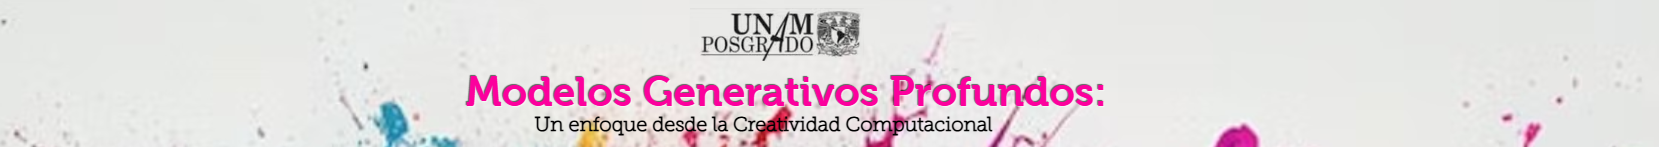

# WGAN-GP Condicional usando el dataset CelebA Faces

En este cuaderno, recorreremos paso a paso el proceso necesario para entrenar tu propia Red Generativa Adversarial Condicional (Conditional GAN, o CGAN) utilizando el conjunto de datos CelebA Faces.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    optimizers,
)

## 0. Parámetros

In [3]:
IMAGE_SIZE = 64
CHANNELS = 3
CLASSES = 2
BATCH_SIZE = 128
Z_DIM = 32
LEARNING_RATE = 0.00005
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
EPOCHS = 20
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
LABEL = "Blond_Hair"

## 1. Preparar los datos

Asume que ya descargaste el dataset CelebFaces Attributes desde https://www.kaggle.com/datasets/jessicali9530/celeba-dataset y se encuentra en tu drive.

In [4]:
import os, shutil, zipfile

# Ruta en Google Drive
drive_path = "/content/drive/MyDrive/Colab Notebooks/CursoIAGenerativa/notebooks/Datasets/CelebAFaces/archive.zip"

# Rutas locales
local_zip_path = "/content/dataset.zip"
local_extract_path = "/content/celebA_dataset_local"

# =========================================================
# 1️. Copiar el ZIP desde Drive a almacenamiento local
# =========================================================
if not os.path.exists(local_extract_path):
    print("📂 Copiando dataset.zip desde Drive a almacenamiento local...")
    shutil.copy(drive_path, local_zip_path)

    # =========================================================
    # 2️. Descomprimir el archivo
    # =========================================================
    print("📦 Descomprimiendo dataset.zip...")
    with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
        zip_ref.extractall(local_extract_path)

    print("✅ Dataset descomprimido en:", local_extract_path)
else:
    print("✅ Dataset local ya disponible:", local_extract_path)

# =========================================================
# 3️. Definir ruta base para el pipeline
# =========================================================
# Como al descomprimir se crea una carpeta 'dataset/' con las imágenes dentro,
# apuntamos directamente a ella.
DATASET_PATH = os.path.join(local_extract_path, "dataset")

print("📌 DATASET_PATH =", DATASET_PATH)

📂 Copiando dataset.zip desde Drive a almacenamiento local...
📦 Descomprimiendo dataset.zip...
✅ Dataset descomprimido en: /content/celebA_dataset_local
📌 DATASET_PATH = /content/celebA_dataset_local/dataset


In [5]:
# Cargar el conjunto de datos de etiquetas
attributes = pd.read_csv("/content/celebA_dataset_local/list_attr_celeba.csv")
print(attributes.columns)
attributes.head()

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [6]:
# Cargar los datos
labels = attributes[LABEL].tolist()
int_labels = [x if x == 1 else 0 for x in labels]

In [7]:
train_data = utils.image_dataset_from_directory(
    "/content/celebA_dataset_local/img_align_celeba",
    labels=int_labels,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 202599 files belonging to 2 classes.


In [8]:
# Preprocesar los datos
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(
    lambda x, y: (preprocess(x), tf.one_hot(y, depth=CLASSES))
)

In [9]:
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()

In [10]:
# Muestra algunas de los rostros del conjunto de entrenamiento
train_sample = sample_batch(train)

In [11]:
def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Despliega n imágenes aleatorias de cada uno de los arreglos provistos
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

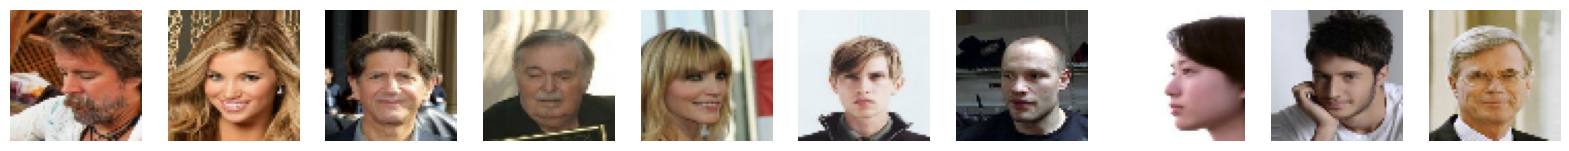

In [12]:
display(train_sample, cmap=None)

## 2. Construye la CGAN

In [13]:
critic_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
label_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CLASSES))
x = layers.Concatenate(axis=-1)([critic_input, label_input])
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid")(x)
critic_output = layers.Flatten()(x)

critic = models.Model([critic_input, label_input], critic_output)
critic.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 64, 64, 2) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64, 5) │          0 │ input_layer[0][0… │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      5,184 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 32, 32,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │    131,200 │ leaky_re_lu[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 16, 16,    │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 16,    │          0 │ leaky_re_lu_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 128) │    262,272 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 8, 8, 128) │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8, 8, 128) │          0 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 4, 4, 128) │    262,272 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 4, 4, 128) │          0 │ conv2d_3[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 4, 4, 128) │          0 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 1, 1, 1)   │      2,049 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ conv2d_4[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 662,977 (2.53 MB)

 Trainable params: 662,977 (2.53 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
generator_input = layers.Input(shape=(Z_DIM,))
label_input = layers.Input(shape=(CLASSES,))
x = layers.Concatenate(axis=-1)([generator_input, label_input])
x = layers.Reshape((1, 1, Z_DIM + CLASSES))(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=4, strides=2, padding="same", activation="tanh"
)(x)
generator = models.Model([generator_input, label_input], generator_output)
generator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 34)        │          0 │ input_layer_2[0]… │
│ (Concatenate)       │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 34)  │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 4, 4, 128) │     69,632 │ reshape[0][0]     │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 4, 4, 128) │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 4, 4, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 8, 8, 128) │    262,144 │ leaky_re_lu_4[0]… │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 16, 16,    │    262,144 │ leaky_re_lu_5[0]… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 32, 32,    │    131,072 │ leaky_re_lu_6[0]… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 64, 64, 3) │      3,075 │ leaky_re_lu_7[0]… │
│ (Conv2DTranspose)   │                   │            │                 

 Total params: 729,859 (2.78 MB)

 Trainable params: 728,963 (2.78 MB)

 Non-trainable params: 896 (3.50 KB)

In [15]:
class ConditionalWGAN(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(ConditionalWGAN, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(ConditionalWGAN, self).compile(run_eagerly=True)
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def gradient_penalty(
        self, batch_size, real_images, fake_images, image_one_hot_labels
    ):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(
                [interpolated, image_one_hot_labels], training=True
            )

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        real_images, one_hot_labels = data

        image_one_hot_labels = one_hot_labels[:, None, None, :]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=IMAGE_SIZE, axis=1
        )
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=IMAGE_SIZE, axis=2
        )

        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    [random_latent_vectors, one_hot_labels], training=True
                )

                fake_predictions = self.critic(
                    [fake_images, image_one_hot_labels], training=True
                )
                real_predictions = self.critic(
                    [real_images, image_one_hot_labels], training=True
                )

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(
                    real_predictions
                )
                c_gp = self.gradient_penalty(
                    batch_size, real_images, fake_images, image_one_hot_labels
                )
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)
            )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        with tf.GradientTape() as tape:
            fake_images = self.generator(
                [random_latent_vectors, one_hot_labels], training=True
            )
            fake_predictions = self.critic(
                [fake_images, image_one_hot_labels], training=True
            )
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

In [16]:
# Crea una CGAN
cgan = ConditionalWGAN(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [17]:
if LOAD_MODEL:
    checkpoint_dir = "/content/drive/MyDrive/Colab Notebooks/CursoIAGenerativa/notebooks/Clase13_GANSII/CGAN/checkpoint"

    gen_path = os.path.join(checkpoint_dir, "generator_epoch_000.weights.h5")
    disc_path = os.path.join(checkpoint_dir, "discriminator_epoch_000.weights.h5")

    print(f"📂 Cargando pesos desde:\n- {gen_path}\n- {disc_path}")
    cgan.generator.load_weights(gen_path)
    cgan.critic.load_weights(disc_path)
    print("✅ Pesos del generador y crítico cargados correctamente.")


## 3. Entrenar la CGAN

In [18]:
# Compilar la CGAN
cgan.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [19]:
# =========================================================
# 1. RUTAS BASE EN GOOGLE DRIVE
# =========================================================
base_dir = "/content/drive/My Drive/Colab Notebooks/CursoIAGenerativa/notebooks/Clase13_GANSII/CGAN"

checkpoint_dir = os.path.join(base_dir, "checkpoint")
logs_dir = os.path.join(base_dir, "logs")
output_dir = os.path.join(base_dir, "output")

os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(logs_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)


# =========================================================
# 2. CALLBACK PERSONALIZADO PARA GUARDAR PESOS
# =========================================================
class ModelCheckpointGAN(callbacks.Callback):
    def __init__(self, generator, discriminator, base_path):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.base_path = base_path
        os.makedirs(self.base_path, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        gen_path = os.path.join(self.base_path, f"generator_epoch_{epoch:03d}.weights.h5")
        disc_path = os.path.join(self.base_path, f"discriminator_epoch_{epoch:03d}.weights.h5")
        self.generator.save_weights(gen_path)
        self.discriminator.save_weights(disc_path)
        print(f"Pesos guardados:\n - {gen_path}\n - {disc_path}")


# =========================================================
# 3. CALLBACK DE TENSORBOARD
# =========================================================
tensorboard_callback = callbacks.TensorBoard(log_dir=logs_dir)


# =========================================================
# 4. CALLBACK PARA GENERAR IMÁGENES CONDICIONALES
# =========================================================
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        super().__init__()
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))

        # Generar imágenes para dos etiquetas: 0 (no atributo) y 1 (atributo)
        for label_value, label_name in zip([[1, 0], [0, 1]], ["label_0", "label_1"]):
            labels = tf.constant(np.repeat([label_value], self.num_img, axis=0), dtype=tf.float32)

            generated_images = self.model.generator([random_latent_vectors, labels])
            generated_images = (generated_images * 127.5 + 127.5).numpy()

            save_path = os.path.join(output_dir, f"generated_img_{epoch:03d}_{label_name}.png")
            display(generated_images, save_to=save_path)
            print(f"Imagen generada guardada en: {save_path}")


# =========================================================
# 5️. FORZAR CONSTRUCCIÓN DE MODELOS
# =========================================================
z_dummy = tf.random.normal((1, Z_DIM))
label_vec = tf.constant([[0, 1]], dtype=tf.float32)

# Expandir etiqueta para el crítico
label_map = tf.reshape(label_vec, (1, 1, 1, CLASSES))
label_map = tf.repeat(label_map, IMAGE_SIZE, axis=1)
label_map = tf.repeat(label_map, IMAGE_SIZE, axis=2)

# Ejecutar pasada por los modelos
_ = cgan.generator([z_dummy, label_vec])
_ = cgan.critic([tf.zeros((1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)), label_map])

print("Generador y crítico construidos correctamente.")

Generador y crítico construidos correctamente.


In [20]:

history = cgan.fit(
    train,
    epochs=EPOCHS * 100,
    steps_per_epoch=1,
    callbacks=[
        ModelCheckpointGAN(cgan.generator, cgan.critic, checkpoint_dir),
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Salva los modelos finales
drive_path = "/content/drive/MyDrive/Colab Notebooks/CursoIAGenerativa/notebooks/Clase13_GANSII/"
generator.save(os.path.join(drive_path, "generador_2000_epocas.keras"))
critic.save(os.path.join(drive_path, "critic_2000_epocas.keras"))
#generator.save("./models/generator")
#critic.save("./models/critic")




## Generación de imágenes

In [ ]:
# 0 label
z_sample = np.random.normal(size=(10, Z_DIM))
class_label = np.repeat([[1, 0]], 10, axis=0)
imgs = cgan.generator.predict([z_sample, class_label])
display(imgs, cmap=None)

In [ ]:
# 1 label
z_sample = np.random.normal(size=(10, Z_DIM))
class_label = np.repeat([[0, 1]], 10, axis=0)
imgs = cgan.generator.predict([z_sample, class_label])
display(imgs, cmap=None)